# Chapter3 ニューラルネットワークの基本
## 2. アヤメの分類【サンプルコード】

In [1]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0

     |████████████████████████████████| 6.9MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# 必要なパッケージのインストール
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

## 2.1. アヤメ（Iris）データセット

In [3]:
# データセットのロード
iris = load_iris()

In [4]:
# データセットの説明
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
# データフレームに変換
df = pd.DataFrame(iris.data, columns=iris.feature_names)
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [6]:
# 品種の追加
df['Variety'] = iris.target
df.loc[df['Variety'] == 0, 'Variety'] = 'setosa'
df.loc[df['Variety'] == 1, 'Variety'] = 'versicolor'
df.loc[df['Variety'] == 2, 'Variety'] = 'virginica'
print(df.head())

   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  Variety
0                5.1               3.5  ...               0.2   setosa
1                4.9               3.0  ...               0.2   setosa
2                4.7               3.2  ...               0.2   setosa
3                4.6               3.1  ...               0.2   setosa
4                5.0               3.6  ...               0.2   setosa

[5 rows x 5 columns]


In [7]:
# 基本統計量の確認
print(df.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
count         150.000000        150.000000         150.000000        150.000000
mean            5.843333          3.057333           3.758000          1.199333
std             0.828066          0.435866           1.765298          0.762238
min             4.300000          2.000000           1.000000          0.100000
25%             5.100000          2.800000           1.600000          0.300000
50%             5.800000          3.000000           4.350000          1.300000
75%             6.400000          3.300000           5.100000          1.800000
max             7.900000          4.400000           6.900000          2.500000


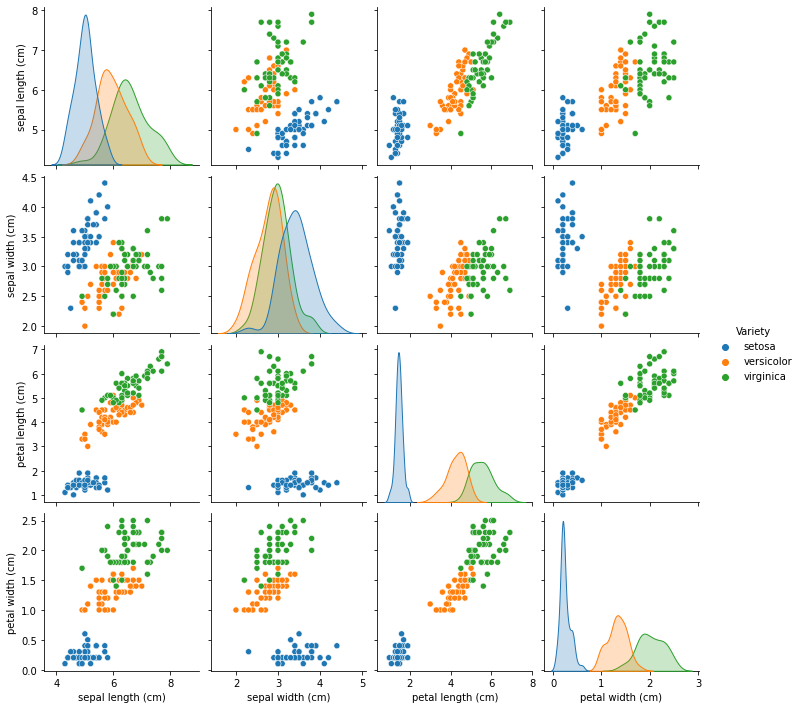

In [8]:
# データセットの可視化
sns.pairplot(df, hue='Variety')
plt.show()

## 2.2. 前準備

In [9]:
# データセットの読み込み
iris = load_iris()
data = iris.data  # 特徴量
label = iris.target  # ラベル（品種）

## 2.3. 訓練データとテストデータの用意

In [10]:
# 学習データとテストデータを分割
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2)

# 学習データとテストデータのサイズの確認
print("train_data size: {}".format(len(train_data)))
print("test_data size: {}".format(len(test_data)))
print("train_label size: {}".format(len(train_label)))
print("test_label size: {}".format(len(test_label)))

train_data size: 120
test_data size: 30
train_label size: 120
test_label size: 30


In [11]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.LongTensor(train_label)  # torch.int64のデータ型に
test_y = torch.LongTensor(test_label)  # torch.int64のデータ型に

In [12]:
# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [13]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(
    dataset=train_dataset,  # データセットの指定
    batch_size=5,  # バッチサイズの指定
    shuffle=True,  # シャッフルするかどうかの指定
    num_workers=2)  # コアの数
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=5,
    shuffle=False,
    num_workers=2)

# ミニバッチデータセットの確認
for data, label in train_batch:
    print("batch data size: {}".format(data.size()))  # バッチの入力データサイズ
    print("batch label size: {}".format(label.size()))  # バッチのラベルサイズ
    break

batch data size: torch.Size([5, 4])
batch label size: torch.Size([5])


## 2.4. ニューラルネットワークの定義

In [14]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
# ハイパーパラメータの定義
D_in = 4  # 入力次元: 4
H = 100  # 隠れ層次元: 100
D_out = 3  # 出力次元: 3
epoch = 100  # 学習回数

In [16]:
# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)
# デバイスの確認
print("Device: {}".format(device))

Device: cuda


## 2.5. 損失関数と最適化関数の定義

In [17]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 2.6. 学習

In [18]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for data, label in train_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(data)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, label)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_label = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_label == label).item() / len(label)

    # ミニバッチの平均の損失と正解率を計算
    batch_train_loss = train_loss / len(train_batch)
    batch_train_accuracy = train_accuracy / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for data, label in test_batch:
            # GPUにTensorを転送
            data = data.to(device)
            label = label.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(data)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, label)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_label = torch.max(y_pred_prob, 1)[1]
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_label == label).item() / len(label)
    # ミニバッチの平均の損失と正解率を計算
    batch_test_loss = test_loss / len(test_batch)
    batch_test_accuracy = test_accuracy / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f} Train_Accuracy: {:.4f}".format(
        batch_train_loss, batch_train_accuracy))
    print("Test_Loss: {:.4f} Test_Accuracy: {:.4f}".format(
        batch_test_loss, batch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(batch_train_loss)
    train_accuracy_list.append(batch_train_accuracy)
    test_loss_list.append(batch_test_loss)
    test_accuracy_list.append(batch_test_accuracy)

---------------------------------------------
Epoch: 1/100
Train_Loss: 0.9609 Train_Accuracy: 0.5000
Test_Loss: 0.8991 Test_Accuracy: 0.6000
---------------------------------------------
Epoch: 2/100
Train_Loss: 0.7520 Train_Accuracy: 0.6833
Test_Loss: 0.7330 Test_Accuracy: 0.6000
---------------------------------------------
Epoch: 3/100
Train_Loss: 0.6300 Train_Accuracy: 0.7250
Test_Loss: 0.6232 Test_Accuracy: 0.7333
---------------------------------------------
Epoch: 4/100
Train_Loss: 0.5602 Train_Accuracy: 0.7833
Test_Loss: 0.5924 Test_Accuracy: 0.6000
---------------------------------------------
Epoch: 5/100
Train_Loss: 0.5075 Train_Accuracy: 0.7667
Test_Loss: 0.5000 Test_Accuracy: 0.9333
---------------------------------------------
Epoch: 6/100
Train_Loss: 0.4711 Train_Accuracy: 0.8417
Test_Loss: 0.4838 Test_Accuracy: 0.7667
---------------------------------------------
Epoch: 7/100
Train_Loss: 0.4401 Train_Accuracy: 0.9083
Test_Loss: 0.4324 Test_Accuracy: 0.9333
-------------

## 2.7. 結果の可視化

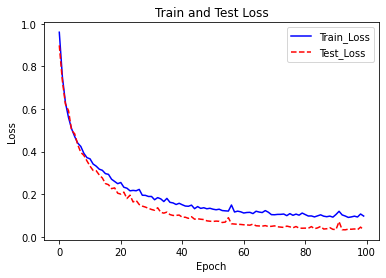

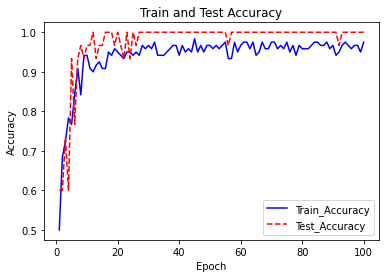

In [19]:
# 損失
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')
plt.legend()

# 表示
plt.show()

## 2.8. 新たにテスト用のデータセットを用意して推定したい場合

In [20]:
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 学習パラメータを保存
torch.save(net.to(device).state_dict(), '3-2_iris_net.pth')

In [21]:
# ハイパーパラメータの定義
D_in = 4  # 入力次元: 4
H = 100  # 隠れ層次元: 100
D_out = 3  # 出力次元: 3

# 保存した学習パラメータを読み込む
net2 = Net(D_in, H, D_out).to(device)
net2.load_state_dict(torch.load('3-2_iris_net.pth', map_location=device))

<All keys matched successfully>

In [22]:
# ニューラルネットワークを評価モードに設定
net2.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    # 初期化
    test_accuracy = 0
    for data, label in test_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(data)
        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_label = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        test_accuracy += torch.sum(y_pred_label == label).item() / len(label)
# ミニバッチの平均の損失と正解率を計算
batch_test_accuracy = test_accuracy / len(test_batch)
# 正解率を表示
print("Accuracy: {:.3f}".format(batch_test_accuracy))

Accuracy: 1.000
